In [1]:
from quspin.operators import hamiltonian,exp_op,quantum_operator # Hamiltonians and operators
from quspin.basis import spinless_fermion_basis_1d, spin_basis_1d # Hilbert space fermion basis
from quspin.tools.block_tools import block_diag_hamiltonian # block diagonalisation
from quspin.tools.measurements import ED_state_vs_time
from quspin.tools.evolution import expm_multiply_parallel
from scipy.optimize import minimize_scalar,minimize,basinhopping, shgo, differential_evolution
import numpy as np # generic math functions
import numba as nb
import matplotlib.pyplot as plt # plotting library
import copy
import matplotlib.pyplot as plt
import scipy
from scipy import sparse, interpolate
import sys,os

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='16' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='16' # set number of MKL threads to run in parallel
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)

In [3]:
#set parameters
L=10
m=0.6
g=0.8
a=1
hop=1
layers=int(L/2)
r=0
charge=int(L/2)-1
length=int(np.math.factorial(L)/(np.math.factorial(L-charge)*np.math.factorial(charge)))

In [4]:
#converge a int to qubit string
def bins(n,L):
    bins=[str(int(j)) for j in bin(n)[2:]]
    bins=''.join(bins)
    l=L-len(bins)
    zbins=[str(0) for x in range (0,l)]
    zbins=''.join(zbins)
    zbins=''.join([zbins,bins])
    return zbins

#counting how much "1" on the even sublattice and how much "0" on the odd sublattice
def counting(state):
    odd=0
    even=0
    num_ones=0
    positionF=[]
    positionAF=[]
    num=list(state)
    for i in range(0,len(num),2):
        if num[i]=="0":
            positionF.append(int(i/2))
            even=even+1
    for i in range(1,len(num)+1,2):
        if num[i]=="1":
            positionAF.append(int((i-1)/2))
            odd=odd+1
    for i in range(len(num)):
        if num[i]=="1":
            num_ones=num_ones+1
    return even,odd,positionF,positionAF,num_ones

In [5]:
#boundary term of ham
def boundary(sym_i,sym_j,i,j):
    string=[]
    pos=[]
    string.append(sym_i)
    for k in range(i+1,j):
        string.append('z')
    string.append(sym_j)
    string=''.join(string)
    for k in range(i,j+1):
        pos.append(k)
    return string,pos

In [6]:
#set the H=H1+...+H4
basis1=spin_basis_1d(L=L,pauli=-1)
hyx_even=[[-1/4,2*i,2*i+1] for i in range(int(L/2))]
hxy_even=[[1/4,2*i,2*i+1] for i in range(int(L/2))]
hyx_odd=[[-1/4,2*i+1,2*i+2] for i in range(int(L/2)-1)]
hxy_odd=[[1/4,2*i+1,2*i+2] for i in range(int(L/2)-1)]
boundary_term1=[[-1/4]+boundary('x','y',0,L-1)[1]]
boundary_term2=[[1/4]+boundary('y','x',0,L-1)[1]]
hzz=[[g/2,2*i,2*i+1] for i in range(int(L/2))]
hz=[[-(m/2+r/2)*(-1)**i,i] for i in range(L)]
hI=[[-g/2,2*i] for i in range(int(L/2))]
hWxx_even=[[-r/4,2*i,2*i+1,2*i+2] for i in range(int(L/2)-1)]
hWxx_odd=[[r/4,2*i+1,2*i+2,2*i+3] for i in range(int(L/2)-1)]
#hWz=[[-(-1)**i*r/2,i] for i in range(L)]
hWb1=[[-r/4]+boundary('x','x',0,L-2)[1]]
hWb2=[[r/4]+boundary('x','x',1,L-1)[1]]
static_hxyeven=[['yx',hyx_even],['xy',hxy_even],['xzx',hWxx_even],['yzy',hWxx_even],[boundary('x','x',0,L-2)[0],hWb1],[boundary('y','y',0,L-2)[0],hWb1]]
static_hxyodd=[['yx',hyx_odd],['xy',hxy_odd],['xzx',hWxx_odd],['yzy',hWxx_odd],[boundary('x','x',1,L-1)[0],hWb2],[boundary('y','y',1,L-1)[0],hWb2],[boundary('x','y',0,L-1)[0],boundary_term1],[boundary('y','x',0,L-1)[0],boundary_term2]]
static_hzz=[['zz',hzz]]
static_hz=[['z',hz]]
static_hI=[['I',hI]]
#static_hW=[['xzx',hWxx],['yzy',hWyy],['z',hWz],[boundary('x','x',0,L-2)[0],hWb1],[boundary('y','y',0,L-2)[0],hWb1],[boundary('x','x',1,L-1)[0],hWb2],[boundary('y','y',1,L-1)[0],hWb2]]
static_ham=static_hxyeven+static_hxyodd+static_hzz+static_hz+static_hI#+static_hW
dynamic=[]
hxyodd=hamiltonian(static_hxyodd,dynamic,basis=basis1,dtype=np.complex128)
hxyeven=hamiltonian(static_hxyeven,dynamic,basis=basis1,dtype=np.complex128)
hzz=hamiltonian(static_hzz,dynamic,basis=basis1,dtype=np.complex128)#*(1/g)
hz=hamiltonian(static_hz,dynamic,basis=basis1,dtype=np.complex128)
ham=hamiltonian(static_ham,dynamic,basis=basis1,dtype=np.complex128)

Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45488\1621243830.py:25: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  hxyodd=hamiltonian(static_hxyodd,dynamic,basis=basis1,dtype=np.complex128)


Hermiticity check passed!
Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45488\1621243830.py:26: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  hxyeven=hamiltonian(static_hxyeven,dynamic,basis=basis1,dtype=np.complex128)
C:\Users\shilong\AppData\Local\Temp\ipykernel_45488\1621243830.py:27: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  hzz=hamiltonian(static_hzz,dynamic,basis=basis1,dtype=np.complex128)#*(1/g)


Hermiticity check passed!
Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45488\1621243830.py:28: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  hz=hamiltonian(static_hz,dynamic,basis=basis1,dtype=np.complex128)
C:\Users\shilong\AppData\Local\Temp\ipykernel_45488\1621243830.py:29: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  ham=hamiltonian(static_ham,dynamic,basis=basis1,dtype=np.complex128)


In [7]:
#compute the vacuum state and vacuum engergy with num method
E0,V0=ham.eigsh(which='SA',k=1)

In [8]:
#set the ham in the Q=0 subspace
basis2=spin_basis_1d(L=L,Nup=charge,pauli=-1)
sub_ham=hamiltonian(static_ham,dynamic,basis=basis2,dtype=np.complex128)

Hermiticity check passed!
Particle conservation check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45488\957029705.py:3: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  sub_ham=hamiltonian(static_ham,dynamic,basis=basis2,dtype=np.complex128)


In [9]:
#compute the qqbar state and qqbar state energy with num method
p=0
psi=np.zeros(2**L,dtype=np.complex128)
E,V=sub_ham.eigsh(which='SA',k=10)
for i in range(length):
    psi[2**L-1-basis2[i]]=V[:,p][i]

In [10]:
eng=[]
for i in range(len(E)):
    eng.append(E[i]-E0[0])
print(eng)

[1.2715891838700308, 1.504109763701864, 1.8157659590040778, 1.504109763701888, 1.8157659590040813, 3.021820632001936, 2.9193475145362306, 2.919347514536251, 2.9889711139119584, 2.98897111391192]


In [11]:
# define the initial state for QAOA
def psi0():
    ini_state1=np.zeros((2**L,1),dtype=np.complex128)[:,0]
    ini_state2=np.zeros((2**L,1),dtype=np.complex128)[:,0]
    ini_state3=np.zeros((2**L,1),dtype=np.complex128)[:,0]
    for i in range(2**(L)):
        if counting(bins(2**L-1-i,L))[0]==1 and counting(bins(2**L-1-i,L))[1]==1 and counting(bins(2**L-1-i,L))[2]==counting(bins(2**L-1-i,L))[3]:
            ini_state1[i]=1
        if counting(bins(2**L-1-i,L))[0]==0 and counting(bins(2**L-1-i,L))[1]==0:
            ini_state2[i]=1
        #if (i==469 or i==725): #or i==347 or i==854 or i==725 or i==365 or i==437 or i==858 or i==363 or i==726 or i==429 or i==693):
        if counting(bins(2**L-1-i,L))[0]==1 and counting(bins(2**L-1-i,L))[1]==0:
            ini_state3[i]=1
    ini_state1=ini_state1/np.linalg.norm(ini_state1)
    ini_state3=ini_state3/np.linalg.norm(ini_state3)
    return ini_state2,ini_state1,ini_state3

In [12]:
#the H1...H4 evoluation of QAOA
def QAOA_state(psi0,layers,parameters):
    evo=[]
    for i in range(layers):
        evo.append(expm_multiply_parallel(hxyeven.tocsr(),a=-1j*parameters[4*i],dtype=dtype_cmplx))
        evo.append(expm_multiply_parallel(hzz.tocsr(),a=-1j*parameters[4*i+1],dtype=dtype_cmplx))
        evo.append(expm_multiply_parallel(hxyodd.tocsr(),a=-1j*parameters[4*i+2],dtype=dtype_cmplx))
        evo.append(expm_multiply_parallel(hz.tocsr(),a=-1j*parameters[4*i+3],dtype=dtype_cmplx))
    for i in range(len(parameters)):
        psi0=evo[i].dot(psi0)
    eng=np.real(np.dot(np.conjugate(psi0),ham.dot(psi0)))
    return psi0,eng.append(expm_multiply_parallel(hz.tocsr(),a=-1j*parameters[4*i+3],dtype=dtype_cmplx))
    for i in range(len(parameters)):
        psi0=evo[i].dot(psi0)
    eng=np.real(np.dot(np.conjugate(psi0),ham.dot(psi0)))
    return psi0,eng

In [13]:
#define the object function
psi1=psi0()[0]
psi2=psi0()[1]
psi3=psi0()[2]
'''
def object_fun(parameters):
    fun=QAOA_state(psi1,layers,parameters)[1]+0.5*QAOA_state(psi2,layers,parameters)[1]
    return fun
'''

def object_fun(parameters):
    fun=QAOA_state(psi3,layers,parameters)[1]
    return fun


In [14]:
#define what method to minimize the object function

def VQE():
    #params = np.zeros((1,4*layers))[0]
    params = np.random.rand(4*layers)
    #params = [-1.5682619386875696, 0.21971224390057, -0.03138909415951295, 1.7851245659805441, 0.5628852288958396, 2.437407019621721, 0.2843886182832214, -1.1754136197932012, 0.9949192159137364, 2.6486242655760077, 0.5280684657676477, -0.060239746546982775, 1.744707778976667, 0.6727739390950436, 0.47630495285023267, 1.1650458636527057, 3.3403919849430252, -0.16666276007755867, -0.2158632189935829, 1.2150069363465057, 0.34307210869529836, 2.203321796604741, -0.15203693675059018, 0.5207576003627894, 1.7795067791756296, -1.5485378801547731, 0.30721567990034127, 0.5225229646720281]
    optimizer = scipy.optimize.minimize(fun=object_fun, x0=params, method='BFGS', options={'gtol': 1e-05, 'eps': 1e-08, 'disp': True})
    return optimizer.x.tolist()

'''
def VQE():
    #params = np.zeros((1,4*layers))[0]
    minimizer_kwargs = {"method": "BFGS"}
    params = np.random.rand(4*layers)
    optimizer = basinhopping(object_fun,params,minimizer_kwargs=minimizer_kwargs,niter=2,T=0.8,disp=True)
    return optimizer.x.tolist()
'''

'\ndef VQE():\n    #params = np.zeros((1,4*layers))[0]\n    minimizer_kwargs = {"method": "BFGS"}\n    params = np.random.rand(4*layers)\n    optimizer = basinhopping(object_fun,params,minimizer_kwargs=minimizer_kwargs,niter=2,T=0.8,disp=True)\n    return optimizer.x.tolist()\n'

In [15]:
#obtain the theta^* parameter
aa=VQE()

AttributeError: 'numpy.float64' object has no attribute 'append'

In [ ]:
print(aa)

In [ ]:
E

In [ ]:
proba_list=np.real(psi*np.conjugate(psi)).tolist()
print(proba_list.index(max(proba_list)))
print(basis1.int_to_state(2**10-469-1))

In [ ]:
import heapq
 
tmp = zip(range(len(proba_list)), proba_list)
large5 = heapq.nlargest(50, tmp, key=lambda x:x[1])
print(large5)

In [ ]:
object_fun(para)

file_VQE_qqbar_para=open('/home/lty/胤/code_for_SCNU_super_computer/PDF_NJL/VQE_qqbar_para/QCpara-N10ma02g08r0L10.txt',mode='w')
file_VQE_qqbar_para.write(str(aa))
file_VQE_qqbar_para.close()

In [ ]:
for i in range(100):
    print([object_fun(np.array(aa)+0.01*np.random.rand(4*layers)),object_fun(np.array(aa))])

compute the PDFs in the quantum computer

In [ ]:
para=aa
#para=eval(open('/home/lty/胤/code_for_SCNU_super_computer/PDF_NJL/VQE_qqbar_para/QCpara-N10ma02g08r0L10.txt',mode='r').read())

In [ ]:
#prapare the Omega and qqbar state with theta^*
vac_state,Evac=QAOA_state(psi1,layers,para)
qqbar_state,Eqqbar=QAOA_state(psi2,layers,para)

In [ ]:
#compute the hadron mass with quantum computing
P_mass=Eqqbar-Evac
print(P_mass)
vol=a

0.9123622300691423


In [ ]:
#the operator in T_ij
def string(coff,pauil,pos):
    string=[]
    string_pos=[]
    basis=spin_basis_1d(L=L,pauli=-1)
    for i in range(pos):
        string.append('z')
        string_pos.append(i)
    string.append(pauil)
    string_pos.append(pos)
    string=''.join(string)
    string_list=[[string,[[coff]+string_pos]]]
    string_dict=dict(H0=string_list)
    string_op=quantum_operator(string_dict,basis=basis,check_herm=False)
    return string_op

In [ ]:
#compute the position space PDF
def quPDFs(psi,index_corr,t1,z1,t2,z2):
    psi1=copy.deepcopy(psi)
    psi=expm_multiply_parallel(ham.tocsr(),a=-1j*vol*t2,dtype=dtype_cmplx).dot(psi)
    psi=string(1,'+',2*z2+int(L/2-1)+(index_corr[1]+1)%2).dot(psi)
    psi=expm_multiply_parallel(ham.tocsr(),a=-1j*vol*(t1-t2),dtype=dtype_cmplx).dot(psi)
    psi=string(1,'-',2*z1+int(L/2-1)+(index_corr[0]+1)%2).dot(psi)
    psi=expm_multiply_parallel(ham.tocsr(),a=1j*vol*t1,dtype=dtype_cmplx).dot(psi)
    quPDFs=np.dot(np.conjugate(psi1),psi)
    return quPDFs

In [ ]:
#compute the position space PDF
PDFs11=[]
PDFs12=[]
PDFs21=[]
PDFs22=[]
for i in range(int(L/2)):
    PDFs11.append(quPDFs(vac_state,[1,1],i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0))
    PDFs12.append(quPDFs(vac_state,[1,2],i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0))
    PDFs21.append(quPDFs(vac_state,[2,1],i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0))
    PDFs22.append(quPDFs(vac_state,[2,2],i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0))

PDFs=np.array(PDFs11)+np.array(PDFs12)+np.array(PDFs21)+np.array(PDFs22)

<ipython-input-24-3cf62e99e64c>:14: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  string_op=quantum_operator(string_dict,basis=basis,check_herm=False)


KeyboardInterrupt: 

#### Fit the PDFs on quantum computer

In [ ]:
#interpolate the position space PDFs
Re_data=np.real(PDFs)
Im_data=np.imag(PDFs)
ym=np.linspace(-(L/2-1)/2,(L/2-1)/2,int(L/2))
coti_ym=np.linspace(-(L/2-1)/2,(L/2-1)/2,1000)
fun_Re_inpol=interpolate.interp1d(ym,Re_data,kind="quadratic")
fun_Im_inpol=interpolate.interp1d(ym,Im_data,kind="quadratic")
num_Re_inpol=fun_Re_inpol(coti_ym)
num_Im_inpol=fun_Im_inpol(coti_ym)

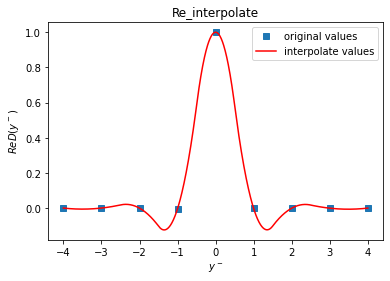

In [ ]:
plot1 = plt.plot(ym, Re_data, 's',label='original values')
plot2 = plt.plot(coti_ym, num_Re_inpol, 'r',label='interpolate values')
plt.xlabel('$y^-$')
plt.ylabel('$ReD(y^-)$')
plt.legend(loc="upper right")
plt.title('Re_interpolate')
plt.show()

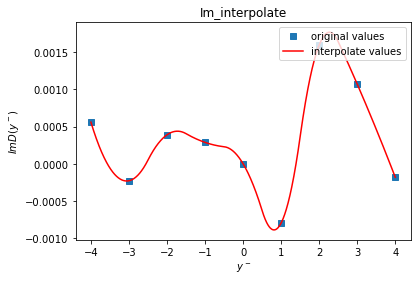

In [ ]:
plot1 = plt.plot(ym, Im_data, 's',label='original values')
plot2 = plt.plot(coti_ym, num_Im_inpol, 'r',label='interpolate values')
plt.xlabel('$y^-$')
plt.ylabel('$ImD(y^-)$')
plt.legend(loc="upper right")
plt.title('Im_interpolate')
plt.show()

In [ ]:
np.savetxt(fname='/home/lty/yin_research/NJL_PDF_code/NJL_PDF_result/QC-posN18ma08g1_vac.txt',X=Re_data+1j*Im_data)